# CFP Composite Rankings

This notebook combines resume and predictive rankings with strength metrics.

**Components:**
- Resume Rankings (30%) - Colley + Win%
- Predictive Rankings (40%) - Massey + Elo
- SOR - Strength of Record (15%)
- SOS - Strength of Schedule (15%)

**Tie-Breaker Logic:**
1. Head-to-head result
2. Record vs common opponents
3. SOS rank
4. SOR rank
5. Composite score

In [17]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# Import metrics module
import sys
sys.path.insert(0, os.path.abspath('..'))

from src.utils.metrics import (
    calculate_sor,
    calculate_sos
)
from src.playoff.bracket import apply_tiebreaker

# Configuration
year = 2025
week = 15

# Output directory
output_dir = Path('./data/output/rankings')
output_dir.mkdir(parents=True, exist_ok=True)

print(f'Season: {year}, Week: {week}')
print(f'Output directory: {output_dir}')


Season: 2025, Week: 15
Output directory: data/output/rankings


In [18]:
# Cell 2: Load Rankings and Games Data
# Load predictive rankings from previous notebook
predictive_rankings = pd.read_csv(output_dir / f'predictive_rankings_{year}_week{week}.csv')

# Load component rankings to reconstruct resume_score
# Note: resume_rankings.csv may be overwritten by notebook 04 with different columns
# So we'll rebuild resume_score from component files in Cell 5
colley_rankings = pd.read_csv(output_dir / f'colley_rankings_{year}_week{week}.csv')
win_pct_rankings = pd.read_csv(output_dir / f'win_pct_rankings_{year}_week{week}.csv')

# Load games data
def load_cached_games(year, week):
    cache_dir = f'./data/cache/{year}'
    parquet_path = f'{cache_dir}/games_w{week}.parquet'
    csv_path = f'{cache_dir}/games_w{week}.csv'
    
    if os.path.exists(parquet_path):
        try:
            return pd.read_parquet(parquet_path)
        except (ImportError, ModuleNotFoundError):
            pass
    
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    
    raise FileNotFoundError(f'No cached data found. Run 01_data_pipeline.ipynb first.')

games_df = load_cached_games(year, week)

print(f'Loaded {len(colley_rankings)} teams from component rankings')
print(f'Loaded {len(games_df)} games')


Loaded 136 teams from component rankings
Loaded 557 games


In [19]:
# Cell 3: Calculate SOR for Each Team
def calculate_team_sor(team, games_df, power_ratings_dict, baseline_rating=0.75, rating_scale=0.25):
    """
    Calculate Strength of Record using metrics module.
    SOR = Probability that average Top-25 team achieves same or better record.
    """
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    
    wins = 0
    losses = 0
    opponent_ratings = []
    
    for _, game in team_games.iterrows():
        if game['home_team'] == team:
            opponent = game['away_team']
            won = game['home_score'] > game['away_score']
        else:
            opponent = game['home_team']
            won = game['away_score'] > game['home_score']
        
        if won:
            wins += 1
        else:
            losses += 1
        
        # Get opponent's composite rating (normalized)
        opp_rating = power_ratings_dict.get(opponent, 0.5)
        opponent_ratings.append(opp_rating)
    
    team_record = {'wins': wins, 'losses': losses}
    
    # Use metrics module SOR calculation
    sor_score = calculate_sor(
        team_record=team_record,
        opponent_ratings=opponent_ratings,
        baseline_rating=baseline_rating,
        rating_scale=rating_scale
    )
    
    return sor_score

# Create power ratings dictionary from predictive rankings
# Normalize predictive scores to 0-1 for opponent strength
scaler = MinMaxScaler()
predictive_rankings['normalized_predictive'] = scaler.fit_transform(
    predictive_rankings[['predictive_score']]
)
power_ratings_dict = dict(zip(
    predictive_rankings['team'],
    predictive_rankings['normalized_predictive']
))

# Calculate SOR for each team
sor_scores = {}
for team in colley_rankings['team']:
    sor_score = calculate_team_sor(team, games_df, power_ratings_dict)
    sor_scores[team] = sor_score

print(f'Calculated SOR for {len(sor_scores)} teams')
print('Sample SOR scores:')
for team, score in list(sor_scores.items())[:5]:
    print(f'  {team}: {score:.4f}')


Calculated SOR for 136 teams
Sample SOR scores:
  Notre Dame: 0.9422
  James Madison: 0.8913
  Alabama: 0.4710
  Ohio State: 0.3557
  BYU: 0.2317


In [20]:
# Cell 4: Calculate SOS for Each Team
def calculate_team_sos(team, games_df, include_oor=True, oor_weight=0.33):
    """
    Calculate Strength of Schedule using metrics module.
    Includes opponent's opponents' records (OOR) to prevent inflated schedules.
    Formula: SOS = (2*OR + OOR)/3 where OR and OOR are win percentages
    """
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    
    opponents = []
    for _, game in team_games.iterrows():
        opponent = game['away_team'] if game['home_team'] == team else game['home_team']
        opponents.append(opponent)
    
    # Get opponent records
    opponents_records = []
    opponents_opp_records = []
    
    for opp in opponents:
        opp_games = games_df[(games_df['home_team'] == opp) | (games_df['away_team'] == opp)]
        
        opp_wins = 0
        opp_losses = 0
        
        # Get opponent's record - EXCLUDE the game against the original team
        # This prevents circular dependency (team beating opponent makes opponent look worse)
        for _, g in opp_games.iterrows():
            # Skip the game between this team and the opponent
            if (g['home_team'] == team and g['away_team'] == opp) or \
               (g['home_team'] == opp and g['away_team'] == team):
                continue
            
            if g['home_team'] == opp:
                if g['home_score'] > g['away_score']:
                    opp_wins += 1
                else:
                    opp_losses += 1
            else:
                if g['away_score'] > g['home_score']:
                    opp_wins += 1
                else:
                    opp_losses += 1
        
        opponents_records.append((opp_wins, opp_losses))
        
        # Get opponent's opponents' records (for OOR calculation)
        opp_opp_records = []
        for _, g in opp_games.iterrows():
            opp_opp = g['away_team'] if g['home_team'] == opp else g['home_team']
            
            # Skip if opponent's opponent is the original team (circular)
            if opp_opp == team:
                continue
            
            opp_opp_games = games_df[
                (games_df['home_team'] == opp_opp) | (games_df['away_team'] == opp_opp)
            ]
            
            opp_opp_wins = 0
            opp_opp_losses = 0
            
            for _, gg in opp_opp_games.iterrows():
                if gg['home_team'] == opp_opp:
                    if gg['home_score'] > gg['away_score']:
                        opp_opp_wins += 1
                    else:
                        opp_opp_losses += 1
                else:
                    if gg['away_score'] > gg['home_score']:
                        opp_opp_wins += 1
                    else:
                        opp_opp_losses += 1
            
            opp_opp_records.append((opp_opp_wins, opp_opp_losses))
        
        opponents_opp_records.append(opp_opp_records)
    
    # Use metrics module SOS calculation
    sos_score = calculate_sos(
        opponents_records=opponents_records,
        opponents_opp_records=opponents_opp_records,
        include_oor=include_oor,
        oor_weight=oor_weight
    )
    
    return sos_score

# Calculate SOS for each team
# Use teams from colley_rankings (all teams should be in both)
sos_scores = {}
for team in colley_rankings['team']:
    sos_score = calculate_team_sos(team, games_df, include_oor=True, oor_weight=0.33)
    sos_scores[team] = sos_score

print(f'Calculated SOS for {len(sos_scores)} teams')
print('Sample SOS scores:')
for team, score in list(sos_scores.items())[:5]:
    print(f'  {team}: {score:.4f}')


Calculated SOS for 136 teams
Sample SOS scores:
  Notre Dame: 0.4730
  James Madison: 0.4850
  Alabama: 0.5557
  Ohio State: 0.4604
  BYU: 0.5289


In [21]:
# Cell 5: Merge All Components
# Reconstruct resume_score from component files (colley + win_pct)
# This avoids issues if resume_rankings.csv was overwritten by notebook 04

# Merge Colley and Win Percentage to rebuild resume rankings
resume_data = colley_rankings.merge(
    win_pct_rankings[['team', 'wins', 'losses', 'win_pct']],
    on='team'
)

# Calculate resume_score (60% Colley, 40% Win%) - same as notebook 02
scaler_resume = MinMaxScaler()
resume_data['colley_norm'] = scaler_resume.fit_transform(resume_data[['colley_rating']])
resume_data['win_pct_norm'] = resume_data['win_pct']  # Already 0-1

resume_data['resume_score'] = (
    0.60 * resume_data['colley_norm'] +
    0.40 * resume_data['win_pct_norm']
)

# Start building composite dataframe
composite_df = resume_data[['team', 'wins', 'losses', 'resume_score']].copy()

# Add predictive rankings
composite_df = composite_df.merge(
    predictive_rankings[['team', 'predictive_score']],
    on='team',
    how='inner'
)

# Add SOR and SOS
composite_df['sor'] = composite_df['team'].map(sor_scores)
composite_df['sos'] = composite_df['team'].map(sos_scores)

print(f'Merged all components for {len(composite_df)} teams')
print()
print('Sample combined data:')
print(composite_df.head())


Merged all components for 136 teams

Sample combined data:
            team  wins  losses  resume_score  predictive_score       sor  \
0     Notre Dame     9       0      1.000000          0.726332  0.942169   
1  James Madison     9       0      0.997132          0.629641  0.891294   
2        Alabama     7       1      0.936868          0.639917  0.471014   
3     Ohio State     9       0      0.982159          0.685048  0.355670   
4            BYU     8       1      0.919564          0.557762  0.231741   

        sos  
0  0.472998  
1  0.484965  
2  0.555692  
3  0.460390  
4  0.528920  


In [22]:
# Cell 6: Normalize and Calculate Composite Score
# Normalize all components to 0-1 scale
scaler = MinMaxScaler()

# Normalize all components to 0-1 scale
# Note: sor_score = -log10(prob), so HIGHER sor_score = harder achievement = BETTER (no inversion needed)
composite_df['resume_norm'] = scaler.fit_transform(composite_df[['resume_score']])
composite_df['predictive_norm'] = scaler.fit_transform(composite_df[['predictive_score']])
composite_df['sor_norm'] = scaler.fit_transform(composite_df[['sor']])  # Higher sor_score = better, no inversion
composite_df['sos_norm'] = scaler.fit_transform(composite_df[['sos']])  # Higher SOS = better

# Define weights
weights = {
    'resume': 0.30,
    'predictive': 0.40,
    'sor': 0.15,
    'sos': 0.15
}

# Calculate composite score
composite_df['composite_score'] = (
    weights['resume'] * composite_df['resume_norm'] +
    weights['predictive'] * composite_df['predictive_norm'] +
    weights['sor'] * composite_df['sor_norm'] +
    weights['sos'] * composite_df['sos_norm']
)

# Sort by composite score
composite_df = composite_df.sort_values('composite_score', ascending=False).reset_index(drop=True)
composite_df['rank'] = range(1, len(composite_df) + 1)

print('='*80)
print('TOP 25 COMPOSITE RANKINGS')
print('='*80)
print()
print(composite_df[[
    'rank', 'team', 'wins', 'losses', 
    'resume_score', 'predictive_score', 'sor', 'sos', 'composite_score'
]].head(25))

TOP 25 COMPOSITE RANKINGS

    rank              team  wins  losses  resume_score  predictive_score  \
0      1        Notre Dame     9       0      1.000000          0.726332   
1      2     James Madison     9       0      0.997132          0.629641   
2      3           Alabama     7       1      0.936868          0.639917   
3      4     South Florida     6       2      0.771826          0.881957   
4      5            Oregon     7       1      0.913955          0.675194   
5      6        Ohio State     9       0      0.982159          0.685048   
6      7           Georgia     8       1      0.919305          0.659114   
7      8        Texas Tech     7       1      0.863568          0.739242   
8      9       North Texas     7       1      0.882122          0.688416   
9     10  Washington State     4       4      0.529618          0.885966   
10    11               USC     5       3      0.706344          0.682052   
11    12          Ole Miss     6       1      0.891015       

In [23]:
# Cell 7: Apply Tie-Breaker Logic
# Check for close rankings and apply tie-breakers
tie_tolerance = 0.01  # Teams within 0.01 of each other need tie-breakers

# Create SOR and SOS rank dictionaries for tie-breaker
sor_ranks = composite_df.set_index('team')['sor'].rank(method='min').to_dict()
sos_ranks = composite_df.set_index('team')['sos'].rank(method='min', ascending=False).to_dict()

print('='*80)
print('TIE-BREAKER ANALYSIS')
print('='*80)
print()

tie_count = 0
for i in range(len(composite_df) - 1):
    team_a = composite_df.iloc[i]
    team_b = composite_df.iloc[i+1]
    
    score_diff = abs(team_a['composite_score'] - team_b['composite_score'])
    
    if score_diff < tie_tolerance:
        tie_count += 1
        print(f'Close ranking detected:')
        print(f'  #{team_a["rank"]} {team_a["team"]} - Score: {team_a["composite_score"]:.4f}')
        print(f'  #{team_b["rank"]} {team_b["team"]} - Score: {team_b["composite_score"]:.4f}')
        print(f'  Difference: {score_diff:.4f}')
        
        # Apply tie-breaker
        try:
            winner, reason = apply_tiebreaker(
                team_a=team_a.to_dict(),
                team_b=team_b.to_dict(),
                games_df=games_df,
                sos_ranks=sos_ranks,
                sor_ranks=sor_ranks,
                tolerance=tie_tolerance
            )
            print(f'  Tie-breaker: {winner} wins ({reason})')
        except Exception as e:
            print(f'  Tie-breaker: Unable to break tie ({str(e)})')
        
        print()

if tie_count == 0:
    print('No close rankings detected requiring tie-breakers.')
else:
    print(f'Total close rankings: {tie_count}')

TIE-BREAKER ANALYSIS

Close ranking detected:
  #4 South Florida - Score: 0.6878
  #5 Oregon - Score: 0.6809
  Difference: 0.0069
  Tie-breaker: Oregon wins (Strength of Schedule (SOS rank: 22.0 vs 80.0))

Close ranking detected:
  #5 Oregon - Score: 0.6809
  #6 Ohio State - Score: 0.6797
  Difference: 0.0012
  Tie-breaker: Oregon wins (Strength of Schedule (SOS rank: 22.0 vs 112.0))

Close ranking detected:
  #7 Georgia - Score: 0.6437
  #8 Texas Tech - Score: 0.6343
  Difference: 0.0094
  Tie-breaker: Georgia wins (Strength of Schedule (SOS rank: 64.0 vs 89.0))

Close ranking detected:
  #8 Texas Tech - Score: 0.6343
  #9 North Texas - Score: 0.6298
  Difference: 0.0045
  Tie-breaker: Texas Tech wins (Strength of Schedule (SOS rank: 89.0 vs 100.0))

Close ranking detected:
  #9 North Texas - Score: 0.6298
  #10 Washington State - Score: 0.6268
  Difference: 0.0030
  Tie-breaker: Washington State wins (Strength of Schedule (SOS rank: 55.0 vs 100.0))

Close ranking detected:
  #10 Wash

In [24]:
# Cell 8: Add Component Ranks
# Add individual component ranks for reference
composite_df['resume_rank'] = composite_df['resume_score'].rank(method='min', ascending=False).astype(int)
composite_df['predictive_rank'] = composite_df['predictive_score'].rank(method='min', ascending=False).astype(int)
# SOR: sor_score = -log10(prob), so HIGHER score = harder achievement = BETTER (rank 1 = best)
composite_df['sor_rank'] = composite_df['sor'].rank(method='min', ascending=False).astype(int)
composite_df['sos_rank'] = composite_df['sos'].rank(method='min', ascending=False).astype(int)

print('Component Rankings for Top 10:')
print()
print(composite_df[[
    'rank', 'team', 'resume_rank', 'predictive_rank', 'sor_rank', 'sos_rank'
]].head(10))

Component Rankings for Top 10:

   rank              team  resume_rank  predictive_rank  sor_rank  sos_rank
0     1        Notre Dame            1                6         1        94
1     2     James Madison            2               26         2        75
2     3           Alabama            5               23         4        13
3     4     South Florida           23                2        30        80
4     5            Oregon            8               14        11        22
5     6        Ohio State            3               12         7       112
6     7           Georgia            7               17        12        64
7     8        Texas Tech           14                4        23        89
8     9       North Texas           11               11        13       100
9    10  Washington State           69                1        72        55


In [25]:
# Cell 9: Export Final Rankings
# Prepare final rankings for export
final_rankings = composite_df[[
    'rank', 'team', 'wins', 'losses',
    'resume_score', 'resume_rank',
    'predictive_score', 'predictive_rank',
    'sor', 'sor_rank',
    'sos', 'sos_rank',
    'composite_score'
]].copy()

# Save to output directory
csv_path = output_dir / f'composite_rankings_{year}_week{week}.csv'
final_rankings.to_csv(csv_path, index=False)

# Also save to root for backward compatibility with other notebooks
final_rankings.to_csv('./final_rankings.csv', index=False)

print('Final rankings exported:')
print(f'  {csv_path}')
print(f'  ./final_rankings.csv (for backward compatibility)')

Final rankings exported:
  data/output/rankings/composite_rankings_2025_week15.csv
  ./final_rankings.csv (for backward compatibility)


---

## Visualization

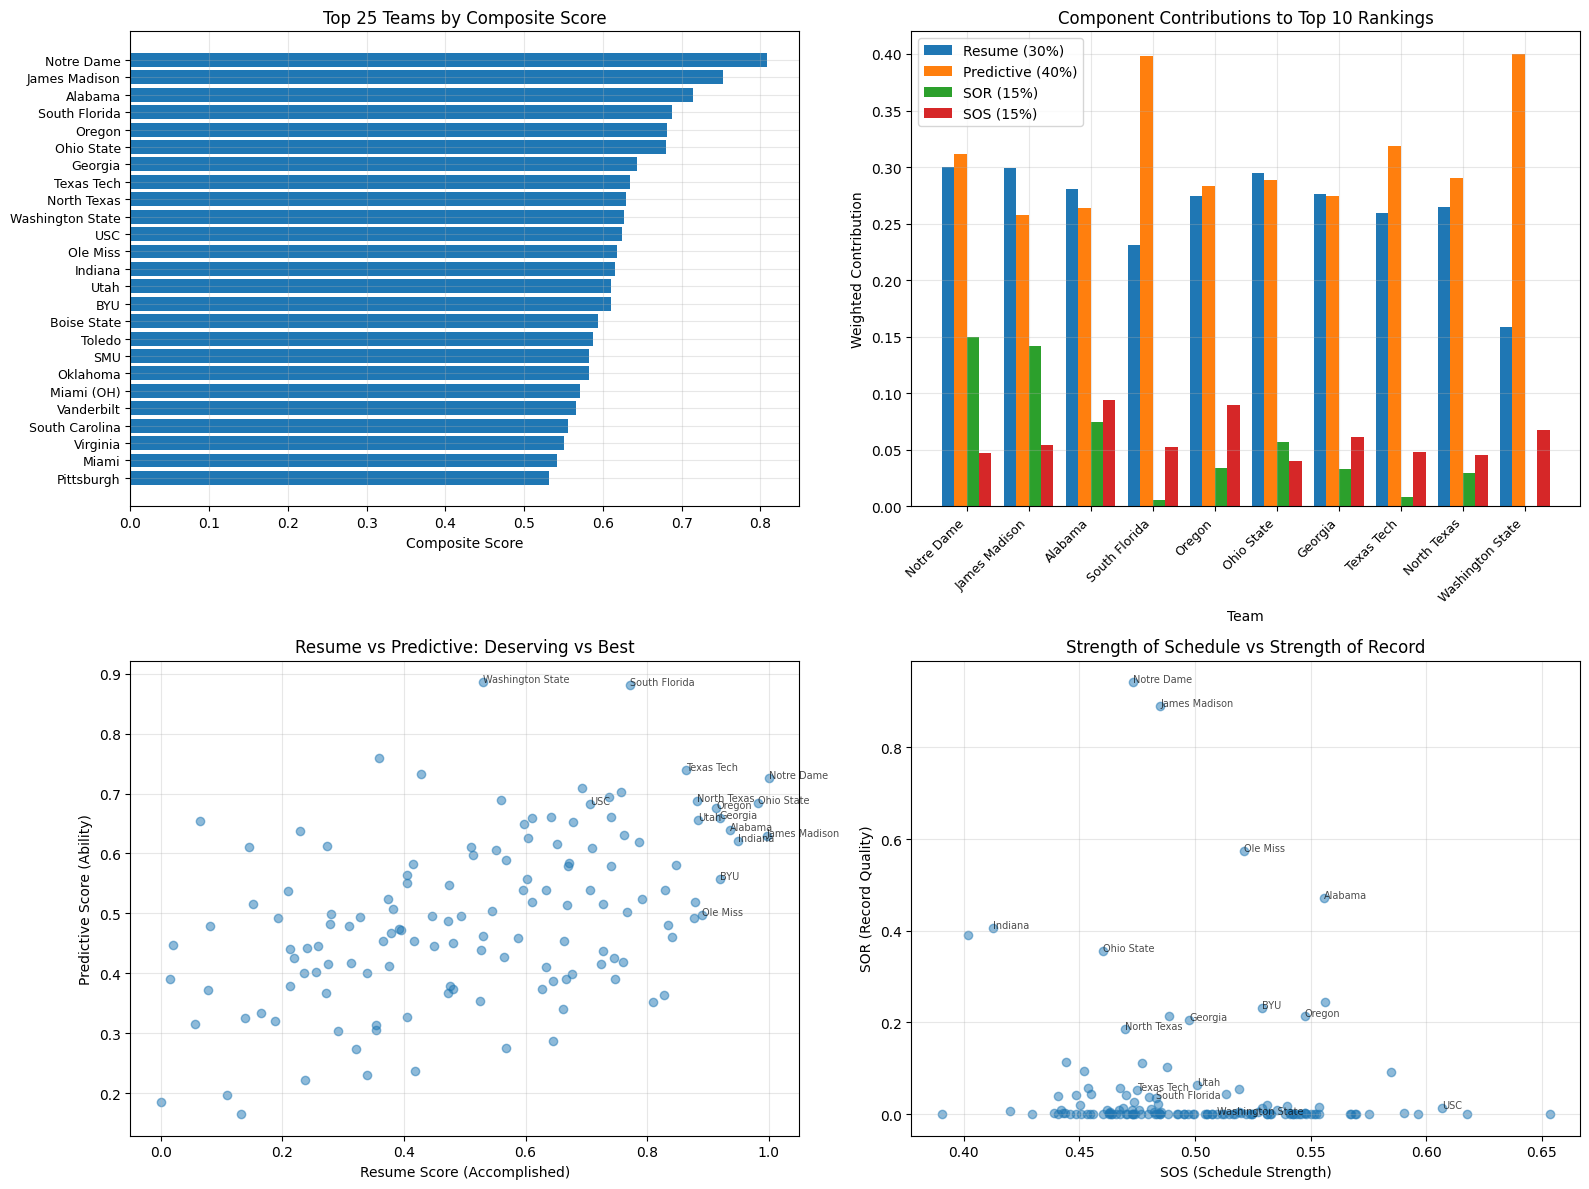

Visualization saved to data/output/visualizations/composite_analysis_2025_week15.png


In [26]:
# Cell 10: Visualize Component Contributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 25 composite scores
ax1 = axes[0, 0]
top25 = final_rankings.head(25)
ax1.barh(range(25, 0, -1), top25['composite_score'])
ax1.set_yticks(range(25, 0, -1))
ax1.set_yticklabels(top25['team'], fontsize=9)
ax1.set_xlabel('Composite Score')
ax1.set_title('Top 25 Teams by Composite Score')
ax1.grid(True, alpha=0.3)

# Plot 2: Component contributions for top 10
ax2 = axes[0, 1]
top10 = composite_df.head(10)
x = np.arange(10)
width = 0.2

ax2.bar(x - 1.5*width, top10['resume_norm'] * weights['resume'], width, label='Resume (30%)')
ax2.bar(x - 0.5*width, top10['predictive_norm'] * weights['predictive'], width, label='Predictive (40%)')
ax2.bar(x + 0.5*width, top10['sor_norm'] * weights['sor'], width, label='SOR (15%)')
ax2.bar(x + 1.5*width, top10['sos_norm'] * weights['sos'], width, label='SOS (15%)')

ax2.set_xlabel('Team')
ax2.set_xticks(x)
ax2.set_xticklabels(top10['team'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Weighted Contribution')
ax2.set_title('Component Contributions to Top 10 Rankings')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Resume vs Predictive scatter
ax3 = axes[1, 0]
ax3.scatter(composite_df['resume_score'], composite_df['predictive_score'], alpha=0.5)
for i, row in composite_df.head(15).iterrows():
    ax3.annotate(row['team'], (row['resume_score'], row['predictive_score']), 
                fontsize=7, alpha=0.7)
ax3.set_xlabel('Resume Score (Accomplished)')
ax3.set_ylabel('Predictive Score (Ability)')
ax3.set_title('Resume vs Predictive: Deserving vs Best')
ax3.grid(True, alpha=0.3)

# Plot 4: SOR vs SOS scatter
ax4 = axes[1, 1]
ax4.scatter(composite_df['sos'], composite_df['sor'], alpha=0.5)
for i, row in composite_df.head(15).iterrows():
    ax4.annotate(row['team'], (row['sos'], row['sor']), 
                fontsize=7, alpha=0.7)
ax4.set_xlabel('SOS (Schedule Strength)')
ax4.set_ylabel('SOR (Record Quality)')
ax4.set_title('Strength of Schedule vs Strength of Record')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir.parent / 'visualizations' / f'composite_analysis_{year}_week{week}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Visualization saved to {output_dir.parent / "visualizations" / f"composite_analysis_{year}_week{week}.png"}')

---

## Summary

Composite rankings complete!

**Component Weights:**
- Resume (30%) - Colley + Win%
- Predictive (40%) - Massey (MOV-capped) + Elo
- SOR (15%) - Record quality given schedule
- SOS (15%) - Schedule difficulty with OOR

**Tie-Breaker Order:**
1. Head-to-head result
2. Record vs common opponents
3. SOS rank
4. SOR rank
5. Composite score

**Next Steps:**
- `04_resume_analysis.ipynb` - Detailed team resume sheets
- `05_playoff_selection.ipynb` - 12-team bracket selection